# Ranking in RecSys

In [1]:
import os
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import cpu_count, Pool

As always we first mount the folder where the dat is contained

In [2]:
data_dir = "../data/trivago"

os.listdir(data_dir)

['first_half.csv', 'half_day.csv', 'second_half.csv']

We load the data we will be playing with next. (If you are running this locally with the original dataset run the commented script)

In [3]:
# df = pd.read_csv(os.path.join(data_dir, "train.csv"))
# start_time = df['timestamp'].min()
# end_time = start_time + 43200  # Half day in seconds
# half_day = df[(df['timestamp'] >= start_time) & (df['timestamp'] < end_time)]
# half_day.to_csv("../data/trivago/half_day.csv", index=False)

df = pd.read_csv(os.path.join(data_dir, "half_day.csv"))

As always it is a good idea to understand the data a little bit. We collect some simple stats. The rows look as follows

In [4]:
df.sample(20)

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
423941,CG4D90N17198,156e113947af4,1541048048,66,interaction item image,63806,MX,"Lake Buena Vista, USA",mobile,NaN,NaN,NaN
720572,FPT7670KJDTH,d1f7a7b22f586,1541037522,7,interaction item image,6380124,BR,"Tamandaré, Brazil",mobile,NaN,NaN,NaN
697404,ECEHO26IBLL7,587c34e834833,1541037005,115,interaction item image,312776,BR,"Aracaju, Brazil",mobile,NaN,NaN,NaN
171858,43H0HGR4RHY3,894435a8f0077,1541031587,5,clickout item,5766136,EC,"Piura, Peru",mobile,NaN,107687|107852|1036474|5766136|2709810|2651196|...,61|67|59|36|33|41|40|18|30|25|49|40|38|40|49|5...
262489,EPY6GCLAJ3D0,a47a5f2b94ee4,1541055832,64,interaction item info,666841,JP,"Sydney, Australia",mobile,NaN,NaN,NaN
74056,DZ2BVCVEQD9L,d26814a3d450e,1541059295,14,interaction item image,127172,UK,"Nairn, United Kingdom",desktop,NaN,NaN,NaN
22043,G0ID1VAYKJ21,e1cc12d3914a7,1541043011,84,interaction item image,5708390,MY,"Pantai Cenang, Malaysia",mobile,NaN,NaN,NaN
651136,WD7NHB3OKXZH,3b10d24ce32f0,1541054228,141,interaction item image,106760,PE,"Lima, Peru",tablet,NaN,NaN,NaN
42737,X4LA56QUVIT3,5b0b693721939,1541041402,90,interaction item image,1038148,AR,"Rome, Italy",desktop,NaN,NaN,NaN
389749,G267K6TZG41L,cc00d3e3cd58f,1541064049,42,interaction item image,100829,RU,"Moscow, Russia",mobile,NaN,NaN,NaN


Let's count the different session_id's that we have as well as the user_id's.

In [5]:
df.nunique()

user_id            54270
session_id         58308
timestamp          43141
step                1756
action_type           10
reference          84383
platform              55
city               10464
device                 3
current_filters     7011
impressions        68573
prices             68776
dtype: int64

With ~58K sessions, we can easily find the len distribution, in number of steps, of each session. Note the log scale.

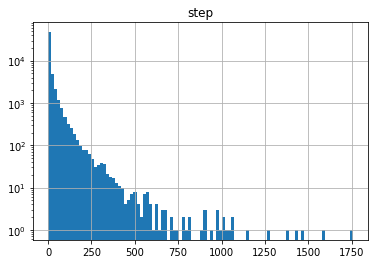

In [6]:
df.groupby('session_id', as_index=False).agg({'step':len}).hist(bins=100, log=True)
plt.show()

Clearly, most of the sessions have a few number of steps. Let's take a look at the number of impressions that the last step has

In [7]:
last_step = df.groupby('session_id', as_index=False).agg({'step':max})
last_step = last_step.merge(df)

Let's only focus on the sessions that have a clickout at the last step.

In [8]:
last_step = last_step[last_step['action_type']=='clickout item']

And we can now find the distribution of item that show up in the last step

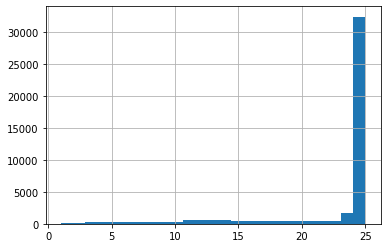

In [9]:
last_step['impressions'].apply(lambda lst: len(lst.split('|'))).hist(bins=25)
plt.show()

We will use that list of impressions as the rank provided for trivago, let's evaluate it under the assumption that the reference is the ground truth. 

In [10]:
last_step.head(1)

,session_id,step,user_id,timestamp,action_type,reference,platform,city,device,current_filters,impressions,prices
0,00000510f1adc,1,WT30CXPIG450,1541064087,clickout item,7281198,IN,"Ganpatipule, India",desktop,NaN,2661832|9222426|7051844|4079190|5752778|468398...,46|26|16|38|12|20|21|27|13|21|36|9|144|19|8|19...


**Mean Reciprocal Rank**

We can easily compute the mean reciprocal rank. 

In [11]:
def reciprocal_rank(row: pd.DataFrame) -> float:

  impressions = row['impressions'].split('|')
  ref = str(row['reference'])

  if ref in impressions:
    return 1/(impressions.index(ref) + 1)
  
  else:
    return 0

mrr = last_step.apply(reciprocal_rank, axis=1).mean()
mrr

0.5120037333107902

That is, the mrr of trivago ranking is ~ 0.512

**Mean Average Precission**

For the MAP we need interpret the list as the retrieve documents, and we only have the reference as ground truth.

In [ ]:
def average_precission(row: pd.DataFrame) -> float:

  impressions = row['impressions'].split('|')
  ref = str(row['reference'])

  if ref in impressions:
    total = 0
    for i in range(len(impressions)):
      if ref == impressions[i]:
        total += 1/(i+1)
    return total/len(impressions)
  else:
    return 0

mAP = last_step.apply(average_precission, axis=1).mean()
mAP

That is the MAP is 0.0311

**Questions:** 

- How does this compare to the MRR? 
- Is there a way to comparing them? 
- Changing only one line in the previous code, can you get MRR?

**Feature Generation**

Note that in order to create the ranking that Trivago has, they had to generate features. Let's create some features associated to the sessions:

A multiprocessing trick: 

1. Split the dataset on the number of cpu's your enviroment has. In our case we just divide the number of sessions into the number of cpu's. 

In [12]:
print("There are {} cpus.".format(cpu_count()))

There are 8 cpus.


As there are only two cpu's, we can split the sessions in half

In [13]:
unique_sessions = df.session_id.unique()
nb_unique = unique_sessions.shape[0]
first_half = df[df.session_id.isin(unique_sessions[:nb_unique//2])]
first_half.to_csv(os.path.join(data_dir, "first_half.csv"), index=False)
second_half = df[df.session_id.isin(unique_sessions[nb_unique//2:])]
second_half.to_csv(os.path.join(data_dir, "second_half.csv"), index=False)

2. Create the logic for processing each file, note that the process should read the file inside:

**Question:**

Can you pass the file to the process directly as an argument? Explore the pros and cons of this.


In [15]:
feature_functions = []
feature_names = []

def feature1(group):

  clickouts = group['action_type'] == 'clickout item'
  
  return clickouts.sum()

feature_functions.append(feature1)
feature_names.append('nb_clickouts')

def feature2(group):

  if group['action_type'].values[-1] == 'clickout item':

    impressions = {imp: 0 for imp in group['impressions'].values[-1].split('|')}
    for ref in group['reference'][:-1]:
      if ref in impressions:
        impressions[ref] += 1

    most_interacted = sorted(impressions, key=lambda w: impressions[w])[-1]

    if impressions[most_interacted]:
      return most_interacted
    else:
      return -1
  else:
    return -1 

feature_functions.append(feature2)
feature_names.append('most_interacted_item')

#############################################################
############## WRITE A COUPLE OF FEATURES HERE ##############

# def feature3(group):
  # Write here
#  return 3

# feature_functions.append(feature3)
# feature_names.append('your feature 3')

# def feature4(group):
  # Write here
#  return 4

# feature_functions.append(feature4)
# feature_names.append('your feature 4')

#############################################################


def extract_features(group):

  return pd.Series([feature(group) for feature in feature_functions], index=feature_names)

def process_file(file_path):

  smaller_df = pd.read_csv(file_path)

  return smaller_df.groupby('session_id', as_index=False).apply(extract_features)

In [ ]:
pool = Pool(2)
file_names = [os.path.join(data_dir, 'first_half.csv'), os.path.join(data_dir, 'second_half.csv')]
features = pool.map(process_file, file_names)
pool.terminate()

In [ ]:
features[0].head(5)

Let's benchmark the time it takes to do this computations with and without 

In [ ]:
start_time = time()
pool = Pool(2)
file_names = [os.path.join(data_dir, 'first_half.csv'), os.path.join(data_dir, 'second_half.csv')]
features = pool.map(process_file, file_names)
pool.terminate()
end_time = time()
print("It took {} seconds".format(end_time-start_time))

In [ ]:
start_time = time()
df = pd.read_csv(os.path.join(data_dir, "half_day.csv"))
df.groupby('session_id', as_index=False).apply(extract_features)
end_time = time()
print("It took {} seconds".format(end_time-start_time))

So, the gain in speed is 20-25%. This increases significantly with the number of cpu's, allowing to a faster iteration process.